## SSDS3 Day 2 hands-on sessions 

### 1. Distributed word2vec word representations

In the first part of this hands-on we will consider word embeddings that can be obtained using word2vec.
Fully setting up the distributed word2vec code will not be covered, but you can find the code on github
at https://github.com/jhzab/dist_w2v with accompanying installation instructions. For this hands-on we will
will use pregenerated word embeddings for our experiments. The distributded wordd2vec code not only works
faster than the original version, but also gives embeddings that perform better on a series of benchmark tasks in natural language processing.

For the vanilla (single machine) version of word2vec see https://code.google.com/archive/p/word2vec/

First let's see a dataset of song lyrics.

In [22]:
import pandas as pd
df = pd.read_csv("./word2vec/lyrics-dataset/english_cleaned_lyrics.csv")


In [23]:
df.head()

,Unnamed: 0,index,song,year,artist,genre,lyrics
0,0,0,ego-remix,2009,beyonce-knowles,Pop,Oh baby how you doing You know I'm gonna cut r...
1,1,1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy it's like you seem s...
2,2,2,honesty,2009,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...
3,3,3,you-are-my-rock,2009,beyonce-knowles,Pop,Oh oh oh I oh oh oh I If I wrote a book about ...
4,4,4,black-culture,2009,beyonce-knowles,Pop,Party the people the people the party it's pop...


In [24]:
import collections
collections.Counter(df["genre"])

Counter({'Country': 14158,
         'Electronic': 6942,
         'Folk': 1689,
         'Hip-Hop': 22654,
         'Indie': 2935,
         'Jazz': 7310,
         'Metal': 21210,
         'Other': 3786,
         'Pop': 34137,
         'R&B': 3336,
         'Rock': 100053})

Now, let's load some pregenerated word embeddings and see what we can do with them.

In [25]:
# Load the word embeddings file 
import numpy as np
lyrics_embeddings = {}

for line in open("./word2vec/lyrics-dataset/word2vec-lyrics-filtered.txt"):
    elems = line.split(" ")
    word = elems[0]    
    vector = np.array([float(x) for x in elems[1:-1]])
    lyrics_embeddings[word] = vector



In [26]:
# Let's play with them a bit\
from sklearn.metrics.pairwise import cosine_similarity
def nearest_words(word, embedding_mat, N):
    sims = list()
    for word2 in embedding_mat:        
        sim = cosine_similarity(embedding_mat[word].reshape(1,-1), embedding_mat[word2].reshape(1,-1))
        sims.append((word2,sim))
    sims_sorted = sorted(sims, key=lambda item: item[1], reverse = True)
    return([(w, s[0][0]) for (w,s) in sims_sorted[0:N]])





In [27]:
print(nearest_words("monkey", lyrics_embeddings, 10)) 
print(nearest_words("river", lyrics_embeddings, 10))
# feel free to try to call this function with your own words!

[('monkey', 0.9999999999999997), ('monkeys', 0.7102549103023252), ('gorilla', 0.6353993328752158), ('ape', 0.6170222000539058), ('snake', 0.6056618152127398), ('rabbit', 0.5765782856594838), ('lizard', 0.5755524743594628), ('frog', 0.5715548330798943), ('baboon', 0.567928686786241), ('cat', 0.5593392101016472)]
[('river', 0.9999999999999993), ('creek', 0.7994444158607223), ('lake', 0.7919587394285413), ('rivers', 0.7777562192527995), ('canal', 0.7221762027374157), ('riverbed', 0.672235437668091), ('lakes', 0.6199875919162294), ('pond', 0.6074254808708804), ('dam', 0.6032722273616916), ('riverside', 0.5954112092982352)]


Now, let's use the word embeddings to generate embeddings of entire texts (entire lyrics for a given song) and analyze them.

In [28]:
import nltk

In [29]:
# Let's now generate song-lyric embeddings from word embeddings 
import nltk
from nltk.corpus import stopwords

class_map = {"Jazz":0, "Metal":1}
df_filtered = df[(df.genre == "Jazz") | (df.genre=="Metal")]
df_sampled = df_filtered.sample(n = 5000, replace = False, random_state = 42)
df_sampled = df_sampled.reset_index(drop=True)


In [30]:
# to get a representation of a larger text we simply average embeddings of it's content words
# content words (in contrast to stopwords) are all words that are not very frequent and 
# non-informative (such as "the" or "he")

feats = list()
labels = list()


for i, row in df_sampled.iterrows():
    if row["genre"] not in class_map:
        continue
        
    if i % 500 == 0:
        print("Currently at %d out of %d." % (i, df_sampled.shape[0]))
    
    labels.append(class_map[row["genre"]])
    
    tokens = [t.lower() for t in nltk.word_tokenize(row["lyrics"])]  
    token_feats_list = list()
    for t in tokens:
        if t in lyrics_embeddings and t not in stopwords.words('english'):
            token_feats_list.append(lyrics_embeddings[t])
    if(len(token_feats_list) > 0):
        token_feats = np.mean(token_feats_list, axis = 0)
    else:
        # in the unlikely (but possible) case that no tokens of a songs lyrics end up
        # in tokens_list we generate a random vector as the embedding representation of that song
        token_feats = np.random.normal(loc = 0, scale = 1, size = next(iter(lyrics_embeddings.values())).shape[0]) 
    feats.append(token_feats)

print(len(labels))
print(len(feats))

Currently at 0 out of 5000.
Currently at 500 out of 5000.
Currently at 1000 out of 5000.
Currently at 1500 out of 5000.
Currently at 2000 out of 5000.
Currently at 2500 out of 5000.
Currently at 3000 out of 5000.
Currently at 3500 out of 5000.
Currently at 4000 out of 5000.
Currently at 4500 out of 5000.
5000
5000


In [31]:
# some boilerplate visualization code (you can also try TSNE from sklearn.manifold.TSNE but in this case it did not
# provide radically better visualizations, but took somewhat longer to run, so we will stick to PCA)

from sklearn.decomposition import PCA
from ggplot import *
import pandas as pd
import matplotlib
from sklearn.preprocessing import StandardScaler

def visualize_embeddings(X,y, limit = "auto"):
    pca = PCA(n_components=2)
    embeds = StandardScaler().fit_transform(X)
    pca_result = pca.fit_transform(embeds)    
    df_pca = pd.DataFrame.from_dict({"pca1" : pca_result[:,0], "pca2" : pca_result[:,1], "label" : y})

    if limit == "auto":
        chart = ggplot(df_pca, aes(x="pca1", y="pca2", color="label") ) \
            + geom_point(size=75,alpha=0.8) \
            + ggtitle("First and Second Principal Components colored by class") \
        
    else:
        chart = ggplot(df_pca, aes(x="pca1", y="pca2", color="label") ) \
            + geom_point(size=75,alpha=0.8) \
            + ggtitle("First and Second Principal Components colored by class") \
            + xlim(-limit, limit) \
            + ylim(-limit, limit)
            
    chart.show()


C:\users\mladen\anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\users\mladen\anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\users\mladen\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


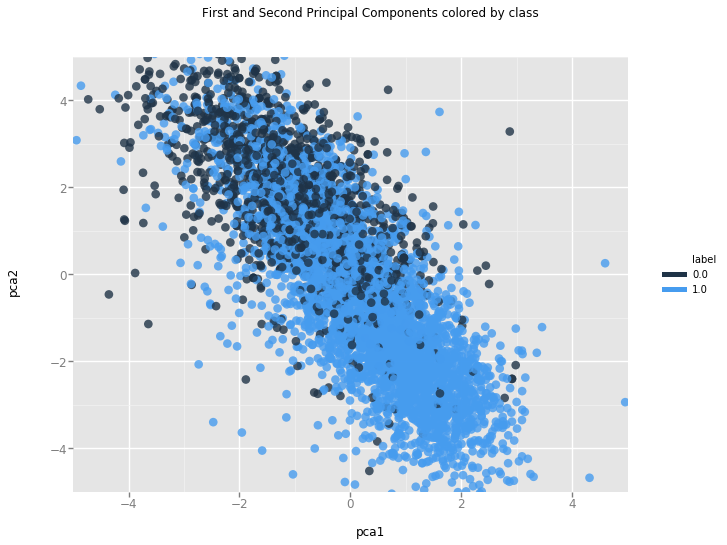

In [33]:
# visualizing different genres in the song-lyric embedding space
X = np.array(feats)
y = np.array(labels)
visualize_embeddings(X, y, limit = 5)

Having seen this visualization, do you think a classifier would do well on this classification task?

In [34]:
# prepare train and test sets for classification experiments
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=42)

In [54]:
# training some classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

dummy = DummyClassifier()
dummy.fit(train_X, train_y)
    
logreg = LogisticRegression(C=1)
logreg.fit(train_X, train_y)

dummy_pred = dummy.predict(test_X)
logreg_pred = logreg.predict(test_X)
    
F1_dummy = f1_score(y_true = test_y, y_pred = dummy_pred, average = "micro")
F1_logreg = f1_score(y_true = test_y, y_pred = logreg_pred, average = "micro")
    
print("Baseline F1 score - ", F1_dummy)
print("Model F1 score - ", F1_logreg)

Baseline F1 score -  0.6392
Model F1 score -  0.9064


Why do we use F1 and not accuracy to evaluate the model?

How does the value of C affect results? Why?

### 2. Graph based representations

Moving on from words to graph data. Here, instead of on words, embeddings are derived on graph nodes. Such embeddings implicitly contain structural information for each node. Optionally, supervised features can be supplied to make the embeddings fine tuned to a particular prediction task.

Two popular algorithms that we will consider for this are Deepwalk and Graphsage. Deepwalk is transductive -- it learns a separate embedding for each node. On the other hand, Graphsage is inductive -- it learns a function which, given a node and it's neighbourhood, outputs an embedding for the node. Some important advantages of Graphsage include:
* it has much fewer parameters, so the training is considerably faster and scales well to large graphs
* it can generalize better and faster to generate embeddings of unseen nodes making it especially appropriate for graphs that change through time (very often found in practical applications)
* it can be supervised, by also accounting for additional node-level features when constructing the embeddings

You can find an implementation of both algorithms (which was used as a basis for this notebook) here: https://github.com/williamleif/GraphSAGE


First, let's get familiar with the networkx package.

In [56]:
# Now on to the graph embeddings part
# First, let's get a bit more familiar with the networkx package

from networkx.readwrite import json_graph
import networkx as nx
import numpy as np
import json


G=nx.Graph() 
# other possible types include graphs that support directed edges(nx.DiGraph()), graphs that allow multiple edges
# between nodes (nx.MultiGraph()), and those that support both of these concepts (nx.MultiDiGraph())


In [57]:

# adding nodes (nodes can be any hashable object, but let's stick to integers):
G.add_node(1)
G.add_node(2)
G.add_node(3)

In [59]:
# adding edges
G.add_edge(1,2)
G.add_edge(2,3)

C:\users\mladen\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\users\mladen\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\users\mladen\anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\users\mladen\anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be remove

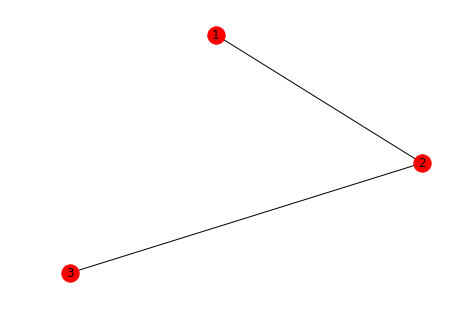

In [60]:
# visualising the graph (no recommended for huge graphs with thousands of nodes and edges)
%matplotlib inline
nx.draw(G, with_labels = True)

C:\users\mladen\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\users\mladen\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\users\mladen\anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\users\mladen\anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be remove

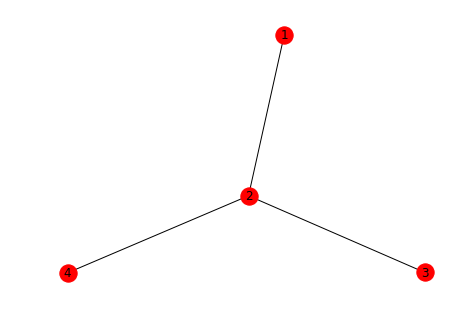

In [61]:
# adding edges that include non-existent nodes automatically creates the missing nodes

G.add_edge(2,4)
nx.draw(G, with_labels = True)

C:\users\mladen\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\users\mladen\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\users\mladen\anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\users\mladen\anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be remove

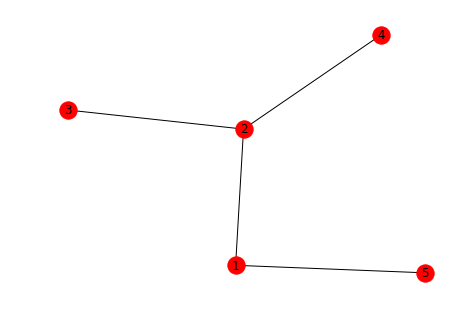

In [62]:
# adding properties to nodes

G.add_node(5,color='blue')
G.add_edge(1,5, weight=0.7)
G.add_edge(1,2, description="the first edge")

nx.draw(G, with_labels = True)



In [63]:
# accessing nodes 

print(G.node[1]) # has no properties
print(G.node[5]) # color -> "blue"

# accessing edges

print(G[1][2]) # description -> "the first edge"
print(G[2][3]) # has no properties

{}
{'color': 'blue'}
{'description': 'the first edge'}
{}


In [64]:
# writing graphs to disk
json_graph_data = json_graph.node_link_data(G)
with open("G.json","w") as outfile:
    json.dump(json_graph_data, outfile)



C:\users\mladen\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\users\mladen\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\users\mladen\anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\users\mladen\anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be remove

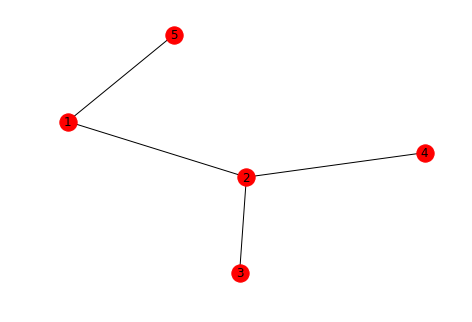

In [65]:
# reading them back
with open("G.json") as infile:
    loaded_json_graph_data = json.load(infile)
G2 = json_graph.node_link_graph(loaded_json_graph_data)

nx.draw(G2, with_labels = True)

Now, let's get familiar with the details of the data format in which you need to prepare your data. 

In [66]:
dataset_dir = "./GraphSAGE/example_data"

G = json_graph.node_link_graph(json.load(open(dataset_dir + "/ppi-G.json")))


In [67]:
print(len(G.nodes()))
print(len(G.edges()))



14755
228431


In [68]:

print(G[1][15])


{'test_removed': False, 'train_removed': False}


In [69]:
print(G.node[0])

{'test': False, 'feature': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], 'val': False, 'label': [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0]}


In [70]:
labels = json.load(open(dataset_dir + "/ppi-class_map.json"))
print(len(labels))
print(labels['1'])

labels = {int(key):val for key, val in labels.items()} 

14755
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0]


In [71]:
feats_id_map = json.load(open(dataset_dir + "/ppi-id_map.json"))
len(feats_id_map)
print(feats_id_map['0'])

feat_id_map = {int(key):val for key, val in feats_id_map.items()} 

0


In [74]:
feats = np.load(dataset_dir + "/ppi-feats.npy")
print(feats[0])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0.]


In [20]:
# another optional requirement for the unsupervised variants of graphsage
# is a file with generated random walks along the graph, this can be generated
# using the graphsage.utils.randomwalks function

Time to train the models.

In [21]:

# *************************************************************
# run the model at the command line ... (commands should be run from the graphsage folder)

# python -m graphsage.supervised_train --train_prefix ./example_data/ppi --model graphsage_mean --sigmoid
# python -m graphsage.unsupervised_train --train_prefix ./example_data/ppi --model graphsage_mean --max_total_steps 1000 --validate_iter 10
# python -m graphsage.unsupervised_train --train_prefix ./example_data/ppi --model n2v --max_total_steps 1000 --validate_iter 10

# *************************************************************


Now, to evaluate the embeddings on a mutli-label (each example is labeled with one or more classes) classification task.

In [75]:

# first we need to do some preparation

#separate train and test graph node ids
train_ids = [n for n in G.nodes() if not G.node[n]['val'] and not G.node[n]['test']]
test_ids = [n for n in G.nodes() if G.node[n]['test']]

print(len(train_ids))
print(len(test_ids))

9716
3214


In [76]:
# prepare the train labels
train_labels = np.array([labels[i] for i in train_ids])
print(train_labels.shape)

(9716, 121)


In [79]:
# preapare the test labels
test_labels = np.array([labels[i] for i in test_ids])
print(test_labels.shape)

# careful if you have a single label to turn it into a column vector

# if train_labels.ndim == 1:
#    train_labels = np.expand_dims(train_labels, 1)


(3214, 121)


In [80]:
## prepare the training data (only the features - these are NOT the embeddings, just the node features)

feats2 = feats # feats2 will be a slightly modified version of feats
## Logistic gets thrown off by big counts, so log transform num comments and score
feats2[:,0] = np.log(feats2[:,0]+1.0)
feats2[:,1] = np.log(feats2[:,1]-min(np.min(feats2[:,1]), -1))
train_feats = feats2[[feat_id_map[id] for id in train_ids]] 
test_feats = feats2[[feat_id_map[id] for id in test_ids]] 

print(train_feats.shape)
print(test_feats.shape)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_feats)
train_feats = scaler.transform(train_feats)
test_feats = scaler.transform(test_feats)




(9716, 50)
(3214, 50)


In [81]:
def load_embeddings(results_dir):    
    embeds = np.load(results_dir + "/val.npy")
    embed_id_map = {}
    with open(results_dir + "/val.txt") as fp:
        for i, line in enumerate(fp):
            embed_id_map[int(line.strip())] = i
    train_embeds = embeds[[embed_id_map[id] for id in train_ids]] 
    test_embeds = embeds[[embed_id_map[id] for id in test_ids]]
    return train_embeds, test_embeds

train_embeds_deepwalk, test_embeds_deepwalk = load_embeddings("./GraphSAGE/unsup-example_data/n2v_small_0.000010")
print("Deepwalk embeds shapes:")
print(train_embeds_deepwalk.shape)
print(test_embeds_deepwalk.shape)

train_embeds_GSunsup, test_embeds_GSunsup = load_embeddings("./GraphSAGE/unsup-example_data/graphsage_mean_small_0.000010")
print("Graphsage unsupervised embeds shapes:")
print(train_embeds_GSunsup.shape)
print(test_embeds_GSunsup.shape)






Deepwalk embeds shapes:
(9716, 256)
(3214, 256)
Graphsage unsupervised embeds shapes:
(9716, 256)
(3214, 256)


C:\users\mladen\anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\users\mladen\anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


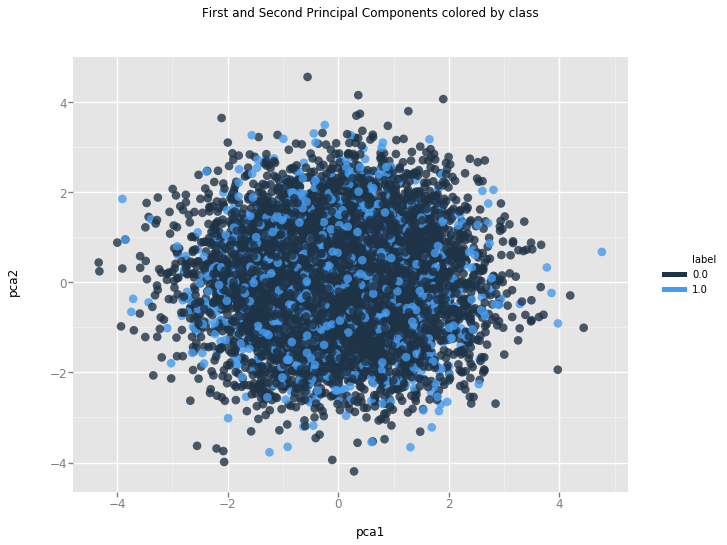

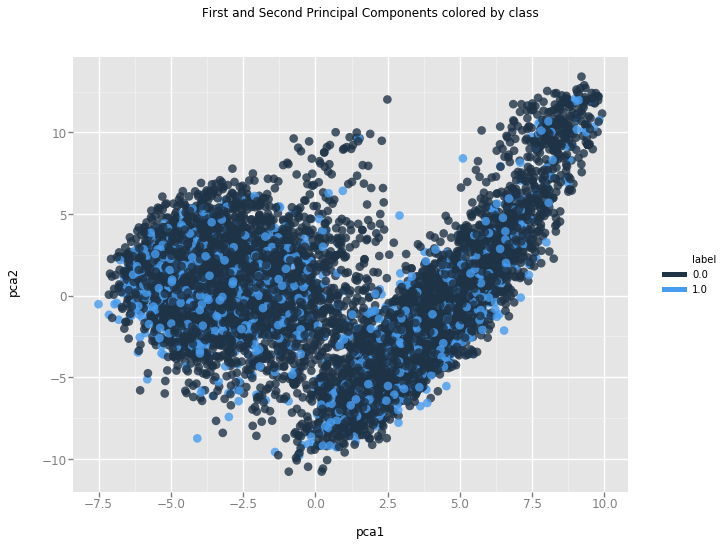

In [83]:
# visualisation of embeddings
label_to_visualize = 5
visualize_embeddings(train_embeds_deepwalk, train_labels[:,label_to_visualize], limit = "auto")    
visualize_embeddings(train_embeds_GSunsup, train_labels[:,label_to_visualize], limit = "auto")

Given the graphs above, how well do you think the classification models will do?

In [84]:
def run_regression(train_X, train_y, test_X, test_y, title):
    print("----------------")
    print(title)
    print("----------------")
    
    np.random.seed(1)
    
    from sklearn.linear_model import SGDClassifier
    from sklearn.linear_model import LogisticRegression
    
    from sklearn.dummy import DummyClassifier
    from sklearn.metrics import f1_score
    from sklearn.multioutput import MultiOutputClassifier
    dummy = MultiOutputClassifier(DummyClassifier())
        
    dummy.fit(train_X, train_y)
    
    # C = 1 is the default value for this hyperparameter (and in this case the best performing one)
    # but in general such values should be tuned on a held-out validation set
    # in this particular case you will get a bit worse result on the GS unsupervised data with C=0.01
    # and a bit better (over 0.47) with C=10
    
    logreg = MultiOutputClassifier(LogisticRegression(C = 1), n_jobs=10)
    logreg.fit(train_X, train_y)

    dummy_pred = dummy.predict(test_X)
    logreg_pred = logreg.predict(test_X)
    
    F1_dummy = f1_score(y_true = test_y, y_pred = dummy_pred, average = "micro")
    F1_logreg = f1_score(y_true = test_y, y_pred = logreg_pred, average = "micro")
    
    print("Baseline F1 score - ", F1_dummy)
    print("Model F1 score - ", F1_logreg)
  

In [85]:
run_regression(train_feats, train_labels, test_feats, test_labels, "Only features")
run_regression(train_embeds_deepwalk, train_labels, test_embeds_deepwalk, test_labels, "Only deepwalk")
run_regression(train_embeds_GSunsup, train_labels, test_embeds_GSunsup, test_labels, "Only graphsage unsupervised")

----------------
Only features
----------------
Baseline F1 score -  0.39119533603973267
Model F1 score -  0.4149222971758588
----------------
Only deepwalk
----------------
Baseline F1 score -  0.39119533603973267
Model F1 score -  0.3943317889163006
----------------
Only graphsage unsupervised
----------------
Baseline F1 score -  0.39119533603973267
Model F1 score -  0.4486715925168998


Can you explain the relative differences in results?

In [86]:
train_dw_feats = np.hstack((train_embeds_deepwalk, train_feats))
test_dw_feats = np.hstack((test_embeds_deepwalk, test_feats))

train_gsu_feats = np.hstack((train_embeds_GSunsup, train_feats))
test_gsu_feats = np.hstack((test_embeds_GSunsup, test_feats))

run_regression(train_dw_feats, train_labels, test_dw_feats, test_labels, "Deepwalk + features")
run_regression(train_gsu_feats, train_labels, test_gsu_feats, test_labels, "Graphsage unsup + features")


----------------
Deepwalk + features
----------------
Baseline F1 score -  0.39119533603973267
Model F1 score -  0.4212901574894735
----------------
Graphsage unsup + features
----------------
Baseline F1 score -  0.39119533603973267
Model F1 score -  0.46224458728982487


How about the differences between these results and those from the previous chunk? Can you explain them?

The implementation that we are using does write supervised embeddings explicitly, but rather generates them under the hood, makes predictions, and only writes the final F1 result (generated identically as above) to a file on disk. For practical purposes you would want to at least get the predictions written to disk. To achieve this you have to make slight modifications the source.

In [101]:
# inspect the graphsage supervised F1 score - it can be found in the test_stats.txt in the model subfolder
# which you will find in the sup-example_data subfolder of GraphSAGE  (we are interested in F1_micro), in
# this case the score is around 0.51
